In [1]:
# MNIST fully connected two hidden layers.
# Proper implementation of Fisher info estimation.
# 0.4 = adapted for pytorch 0.4

# Reload modules
%load_ext autoreload
%autoreload 2
# Inline plots
%matplotlib inline

# Data loading
import torch
import torchvision
import torchvision.transforms as transforms

# Network
from torch import autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Optimizer
import torch.optim as optim

# Standard
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

# Local files
from read_data_permuted import read_data_permuted # Read datasets w/ transformations
from utility import permutate, trans # Data preprocessing
from utility import calc_EWC_loss, calc_L2_loss # Extra loss functions
from utility import calc_Fisher # Calculating Fisher Info.
from utility import test_acc # Calculate test accuracy
from utility import plot_accuracy # Plot accuracy curves

# Parameters
N_task = 3                  # Number of tasks
N_epoch = 1               # Number of epochs
batch_size = 50            # Number of samples in each minibatch
hidden_size = 50           # Number of hidden layer neurons
hidden1_dropout_prob = 0  # First hidden layer dropout probability
hidden2_dropout_prob = 0  # Second hidden layer dropout probability
lambda_L2 = 0.025           # Regularization parameter for L2
lambda_EWC = 15              # Regularization parameter for EWC
sample_size_Fish = 200    # Number of samples to use to estimate Fisher

# Debugging options
bool_debug = False # If true, don't loop through all data but stop after max_iter
max_iter = 10

# Miscellaneous options
use_cuda = 1
num_rec = 2000              # How often to record/display test accuracies, running loss, etc.

# Read datasets and show samples

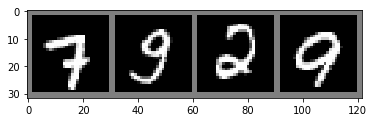

         7          9          2          9


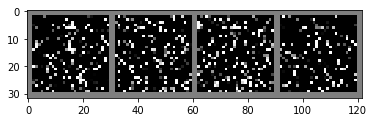

         8          5          3          3


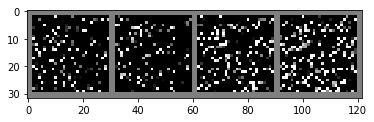

         9          3          9          3


In [2]:
# MNIST-specific settings
# Height and width of images
height = 28
width = 28
# Number of labels
num_labels = 10
# Labels (for display purposes)
classes = ('0','1','2','3','4','5','6','7','8','9')

trainsets, testsets = read_data_permuted(height*width,N_task) # Read datasets

# Number of samples to display per task
batch_size_sample = 4

# Train dataset loaders
trainloaders_sample = []
for i in range(N_task):
    trainloaders_sample.append(torch.utils.data.DataLoader(trainsets[i], batch_size=batch_size_sample, shuffle=True,num_workers=2))

# Show image
def imshow(img):
    img = img/2 + 0.5   # Unnormalize ([-1,1] -> [0,1])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
for i in range(N_task):
    trainloader_sample = trainloaders_sample[i]
    
    dataiter = iter(trainloader_sample)     # Convert to iterator
    images, labels = dataiter.next()        # Get next minibatch
    
    imshow(torchvision.utils.make_grid(images))
    plt.show()
    
    # Show labels
    print(' '.join('%10s' % classes[labels[j]] for j in range(batch_size_sample)))

# Declare networks

In [3]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=400, hidden1_dropout_prob=0.2, hidden2_dropout_prob=0.5):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        #self.fc1_drop = nn.Dropout(p=hidden1_dropout_prob)
        #self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.fc2_drop = nn.Dropout(p=hidden2_dropout_prob)
        self.fc3 = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.fc1_drop(x)
        #x = F.relu(self.fc2(x))
        #x = self.fc2_drop(x)
        x = self.fc3(x)

        return x

# Vanilla
net = Net(
    input_dim = height*width, \
    output_dim = num_labels, \
    hidden_size = hidden_size, \
    hidden1_dropout_prob = hidden1_dropout_prob, \
    hidden2_dropout_prob = hidden2_dropout_prob)

net_L2 = copy.deepcopy(net)
net_EWC = copy.deepcopy(net)

# Define loss and optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer_L2 = optim.SGD(net_L2.parameters(), lr=0.01)
optimizer_EWC = optim.SGD(net_EWC.parameters(),lr=0.01)

#optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
#optimizer_L2 = optim.Adam(net_L2.parameters(), lr=0.001, weight_decay=1e-5)
#optimizer_EWC = optim.Adam(net_EWC.parameters(),lr=0.001, weight_decay=1e-5)

# Train

In [5]:
# Record accuracy
time_list = []

# Each "lists" contains N_task lists that record train accuracy
acc_lists_t = [[] for i in range(N_task)]
acc_L2_lists_t = [[] for i in range(N_task)]
acc_EWC_lists_t = [[] for i in range(N_task)]

# Each "lists" contains N_task lists that record test accuracy
acc_lists = [[] for i in range(N_task)]
acc_L2_lists = [[] for i in range(N_task)]
acc_EWC_lists = [[] for i in range(N_task)]

# Record trained models after each task
param_list_L2 = []
param_list_EWC = []
Fisher_list = []
Fisher_sum = []

# CUDA
if torch.cuda.is_available() and use_cuda:
    net = net.cuda()
    net_L2 = net_L2.cuda()
    net_EWC = net_EWC.cuda()
    criterion = criterion.cuda()
    

t_start = time.time()   # Record total runtime
t_part1 = t_start        # Record partial runtime
for task in range(len(trainsets)):
    trainset = trainsets[task]
    testset = testsets[task]
    
    for epoch in range(N_epoch):
        # Reset running loss
        running_loss = 0.0
        running_loss_L2 = 0.0
        running_loss_EWC = 0.0
        
        # Set up training data
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,num_workers=2)
        
        # For debugging purposes
        num_iter = 0

        # Iterate through all train data
        for i, data in enumerate(trainloader, 0):
            num_iter += 1 # Debugging
            
            inputs, labels = data
            if torch.cuda.is_available() and use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
                
            # Resize input as 1D array
            inputs = inputs.view(-1,height*width)
            
            # Vanilla
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward
            outputs = net(inputs)
            # Backward
            original_loss = criterion(outputs, labels)
            loss = original_loss
            loss.backward()
            # Optimize
            optimizer.step()
            
            # L2 regularization
            # Zero the parameter gradients
            optimizer_L2.zero_grad()
            # Forward
            outputs_L2 = net_L2(inputs)
            # Backward
            original_loss_L2 = criterion(outputs_L2, labels)
            L2_loss = torch.zeros([],requires_grad=True)
            if torch.cuda.is_available() and use_cuda:
                L2_loss = L2_loss.cuda()
            # Single penalty
            #if task > 0:
            #    L2_loss = L2_loss + calc_L2_loss(net_L2, param_list_L2[task-1])
            # Multiple penalties
            for t_num in range(task):
                L2_loss = L2_loss + calc_L2_loss(net_L2, param_list_L2[t_num])
            
            loss_L2 = original_loss_L2 + 0.5*lambda_L2*L2_loss
            loss_L2.backward()
            # Optimize
            optimizer_L2.step()

            # EWC
            # Zero the parameter gradients
            optimizer_EWC.zero_grad()
            # Forward
            outputs_EWC = net_EWC(inputs)
            # Backward
            original_loss_EWC = criterion(outputs_EWC, labels)
            EWC_loss = torch.zeros([], requires_grad = True)
            if torch.cuda.is_available() and use_cuda:
                EWC_loss = EWC_loss.cuda()
            # Single penalty
            #if task > 0:
            #    EWC_loss = EWC_loss + calc_EWC_loss(net_EWC, param_list_EWC[task-1], Fisher_sum)
            # Multiple penalties
            for t_num in range(task):
                EWC_loss = EWC_loss + calc_EWC_loss(net_EWC, param_list_EWC[t_num],Fisher_list[t_num])
            
            loss_EWC = original_loss_EWC + 0.5*lambda_EWC*EWC_loss
            loss_EWC.backward()
            # Optimize
            optimizer_EWC.step()

            # print statistics
            running_loss += loss.data[0]
            running_loss_L2 += loss_L2.data[0]
            running_loss_EWC += loss_EWC.data[0]

            if (i % num_rec) == (num_rec-1): # Print every num_rec mini-batches
            
                t_part2 = time.time()
            
                print('[%d, %5d] loss: %.3f (Vanilla) %.3f (L2) %.3f (EWC), time: %.0f s' % (epoch+1,i+1,running_loss/num_rec,running_loss_L2/num_rec,running_loss_EWC/num_rec,t_part2 - t_part1))
                
                t_part1 = t_part2
                
                # Reset running loss
                running_loss = 0.0
                running_loss_L2 = 0.0
                running_loss_EWC = 0.0
                
                # Record test accuracies for each task
                for j in range(N_task):
                    acc_lists_t[j].append(test_acc(net, trainsets[j], height*width, batch_size, use_cuda))           # Vanilla
                    acc_L2_lists_t[j].append(test_acc(net_L2, trainsets[j], height*width, batch_size, use_cuda))     # L2
                    acc_EWC_lists_t[j].append(test_acc(net_EWC, trainsets[j], height*width, batch_size, use_cuda))   # EWC
                    
                    acc_lists[j].append(test_acc(net, testsets[j], height*width, batch_size, use_cuda))           # Vanilla
                    acc_L2_lists[j].append(test_acc(net_L2, testsets[j], height*width, batch_size, use_cuda))     # L2
                    acc_EWC_lists[j].append(test_acc(net_EWC, testsets[j], height*width, batch_size, use_cuda))   # EWC

            if bool_debug and num_iter >= max_iter:
                break;
    
    # Save models trained on the current task
    current_param_L2 = copy.deepcopy(list(net_L2.parameters()))
    param_list_L2.append(current_param_L2)
    
    current_param_EWC = copy.deepcopy(list(net_EWC.parameters()))
    param_list_EWC.append(current_param_EWC)
    
    # Calculate Fisher Info. for EWC
    
    Fisher = calc_Fisher(net_EWC,testset,sample_size_Fish,use_cuda)
    
    # Record Fisher (for multiple penalties)
    Fisher_list.append(Fisher)
    # Sum Fisher (for single penalty)
    if task == 0:
        Fisher_sum = copy.deepcopy(Fisher)
    else:
        for i in range(len(Fisher)):
            Fisher_sum[i] += Fisher[i]
      
t_finish = time.time()

print('Finished Training')
print('Training time: ' + str(t_finish-t_start) + ' s')

# Convert to arrays
for j in range(N_task):
    acc_lists[j] = np.array(acc_lists[j])
    acc_L2_lists[j] = np.array(acc_L2_lists[j])
    acc_EWC_lists[j] = np.array(acc_EWC_lists[j])
time_list = np.arange(len(acc_lists[0]))


/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,  2000] loss: 0.696 (Vanilla) 0.696 (L2) 0.696 (EWC), time: 4 s
[1,  4000] loss: 0.389 (Vanilla) 0.389 (L2) 0.389 (EWC), time: 115 s
[1,  6000] loss: 0.330 (Vanilla) 0.330 (L2) 0.330 (EWC), time: 118 s
[1,  8000] loss: 0.303 (Vanilla) 0.303 (L2) 0.303 (EWC), time: 110 s
[1, 10000] loss: 0.285 (Vanilla) 0.285 (L2) 0.285 (EWC), time: 110 s
[1, 12000] loss: 0.268 (Vanilla) 0.268 (L2) 0.268 (EWC), time: 110 s
[1, 14000] loss: 0.245 (Vanilla) 0.245 (L2) 0.245 (EWC), time: 210 s
[1,  2000] loss: 0.621 (Vanilla) 0.739 (L2) 0.804 (EWC), time: 373 s
[1,  4000] loss: 0.382 (Vanilla) 0.577 (L2) 0.602 (EWC), time: 379 s
[1,  6000] loss: 0.346 (Vanilla) 0.573 (L2) 0.566 (EWC), time: 387 s
[1,  8000] loss: 0.321 (Vanilla) 0.578 (L2) 0.545 (EWC), time: 233 s
[1, 10000] loss: 0.272 (Vanilla) 0.544 (L2) 0.478 (EWC), time: 111 s
[1, 12000] loss: 0.264 (Vanilla) 0.543 (L2) 0.457 (EWC), time: 111 s
[1, 14000] loss: 0.235 (Vanilla) 0.529 (L2) 0.426 (EWC), time: 141 s
[1,  2000] loss: 0.684 (Vanilla) 0.9

# Plot train

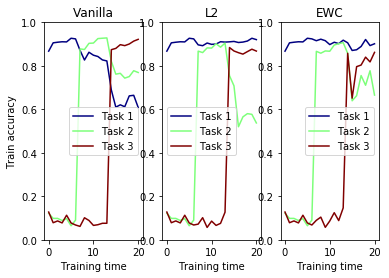

In [6]:
ylabelname = 'Train accuracy'

plot_accuracy(time_list, acc_lists_t, acc_L2_lists_t, acc_EWC_lists_t, N_task, ylabelname, False)

# Plot test

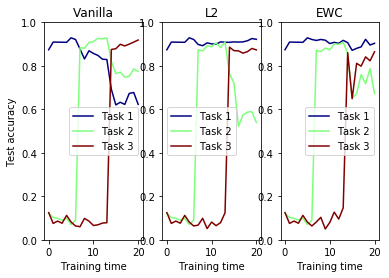

In [7]:
ylabelname = 'Test accuracy'
savename = 'noleg_new_multiple_pen_10_epochs_H=' + str(hidden_size) + '_lambda_L2=' + str(lambda_L2) + '_lambda_EWC=' + str(lambda_EWC)

plot_accuracy(time_list, acc_lists, acc_L2_lists, acc_EWC_lists, N_task, ylabelname, True, savename)

# Plot test averages

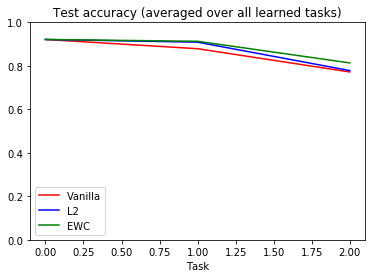

In [8]:
total_time = len(time_list)
task_time = len(time_list)//N_task

acc_avg = np.zeros(N_task)
acc_L2_avg = np.zeros(N_task)
acc_EWC_avg = np.zeros(N_task)

for j in range(N_task):
    for i in range(j+1):
        acc_avg[j] += acc_lists[i][(j+1)*task_time-1]
        acc_L2_avg[j] += acc_L2_lists[i][(j+1)*task_time-1]
        acc_EWC_avg[j] += acc_EWC_lists[i][(j+1)*task_time-1]
    acc_avg[j] /= (j+1)
    acc_L2_avg[j] /= (j+1)
    acc_EWC_avg[j] /= (j+1)
    
plt.figure()
plt.title('Test accuracy (averaged over all learned tasks)')
plt.plot(acc_avg, label = 'Vanilla',c='r')
plt.plot(acc_L2_avg, label = 'L2',c='b')
plt.plot(acc_EWC_avg, label = 'EWC',c='g')
plt.ylim([0,1])
plt.xlabel('Task')
plt.legend()

plt.savefig('N_task=' + str(N_task) + 'new_multiple_pen_10_epochs_H=' + str(hidden_size) + '_lambda_L2=' + str(lambda_L2) + '_lambda_EWC=' + str(lambda_EWC) + '_avg.png')
plt.show()

In [9]:
task_time

7

In [10]:
losses = []

for p1,p2 in zip(net_L2.parameters(),blah):
    losses.append(((p1-p2)**2).sum())
losses
sum(losses)

calc_L2_loss(net_L2,blah)

NameError: name 'blah' is not defined

In [ ]:
dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True,num_workers=2)
for a,b in dataloader:
    a = a.view(1,-1)
    a = Variable(a)
    b = Variable(b)
    a = a.cuda()
    b = b.cuda()
    net.eval()
    #print(F.softmax(net(a)))
    prob = F.softmax(net(a))
    logL = F.log_softmax(net(a))[range(1),b.data]
    net.train()
    
    #a = net(a).data.max(1)[1]
    a=net(a)
    print(a.data.max(1)[1][0])
    break;

In [ ]:
#F.log_softmax(net(a))[range(1),b.data]

In [ ]:
F.log_softmax(net(a))[range(1),torch.multinomial(prob).data]

In [ ]:
Fisher[5].max()